Found 95550 images belonging to 10 classes.
Found 1950 images belonging to 10 classes.
Found 1950 images belonging to 10 classes.
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 203ms/step - accuracy: 0.6144 - loss: 1.1938
Manipulated Test Accuracy: 0.6128205060958862
Found 1950 images belonging to 10 classes.
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 223ms/step - accuracy: 0.3984 - loss: 1.7732
Color Corrected Test Accuracy: 0.4041025638580322
Original Test Accuracy: 0.6764102578163147
Manipulated Test Accuracy: 0.6128205060958862
Color Corrected Test Accuracy: 0.4041025638580322
Epoch 1/10
2986/2986 ━━━━━━━━━━━━━━━━━━━━ 1091s 364ms/step - accuracy: 0.1954 - loss: 2.1422 - val_accuracy: 0.4682 - val_loss: 1.5139
Epoch 2/10
2986/2986 ━━━━━━━━━━━━━━━━━━━━ 653s 218ms/step - accuracy: 0.3119 - loss: 1.9052 - val_accuracy: 0.5513 - val_loss: 1.2930
Epoch 3/10
2986/2986 ━━━━━━━━━━━━━━━━━━━━ 640s 214ms/step - accuracy: 0.3633 - loss: 1.7855 - val_accuracy: 0.6185 - val_loss: 1.1420
Epoch 4/10
2986/2986 ━━━━━━━━━━━━━━━━

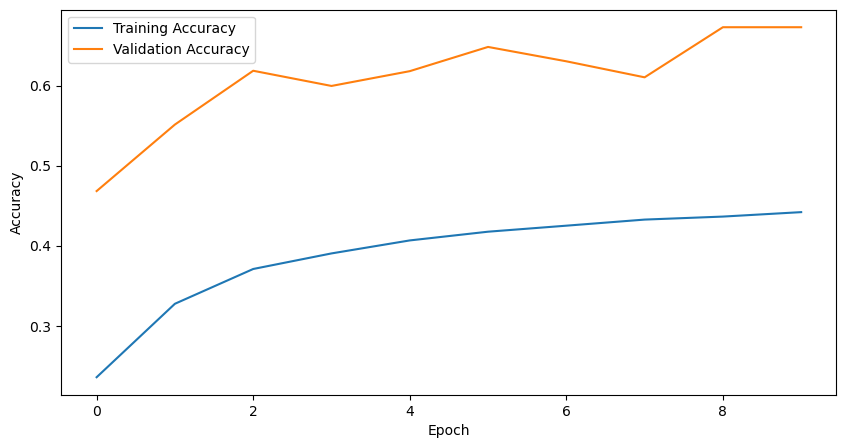

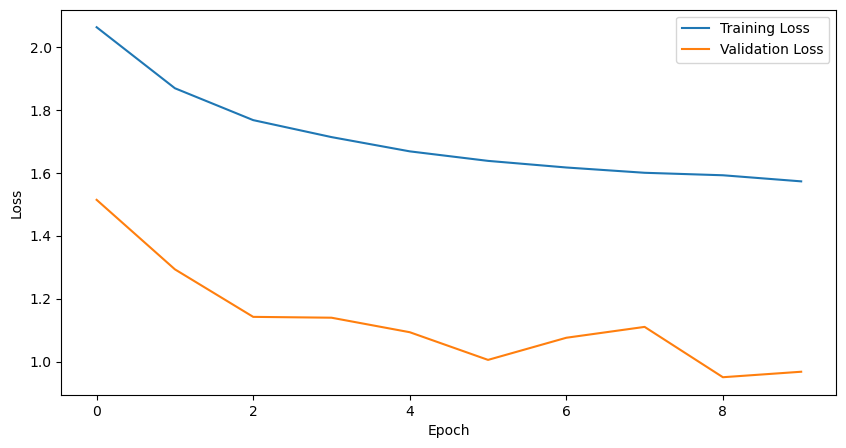

In [10]:
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 1: Dataset Preparation
classes = ['collie', 'dolphin', 'elephant', 'fox', 'moose', 'rabbit', 'sheep', 'squirrel', 'giant+panda', 'polar+bear']
input_path = "C:/Users/ACER/Desktop/Animals"  # Update this path
# Output path
output_path = "C:/Users/ACER/Desktop/Processed"  # Output dizini

# Klasörlerin oluşturulması
if not os.path.exists(output_path):  # Ana dizin kontrolü
    os.makedirs(output_path)  # Eğer yoksa oluştur

# Train ve Test klasörleri için alt dizinlerin oluşturulması
for cls in classes:
    train_path = os.path.join(output_path, 'train', cls)
    test_path = os.path.join(output_path, 'test', cls)

    if not os.path.exists(train_path):  # Train alt dizini kontrolü
        os.makedirs(train_path)  # Eğer yoksa oluştur
    
    if not os.path.exists(test_path):  # Test alt dizini kontrolü
        os.makedirs(test_path)  # Eğer yoksa oluştur

image_size = (128, 128)
for cls in classes:
    class_path = os.path.join(input_path, cls)
    images = os.listdir(class_path)[:650]  # Select first 650 images
    train, test = train_test_split(images, test_size=0.3, random_state=42)

    for img_name in train:
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img_resized = cv2.resize(img, image_size)
        cv2.imwrite(os.path.join(output_path, 'train', cls, img_name), img_resized)

    for img_name in test:
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img_resized = cv2.resize(img, image_size)
        cv2.imwrite(os.path.join(output_path, 'test', cls, img_name), img_resized)

# Step 2: Data Augmentation with Additional Techniques
def augment_image(img):
    augmented_images = [img]
    
    # 1. Bulanıklaştırma
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    augmented_images.append(blurred)
    
    # 2. Kenar Bulma
    edges = cv2.Canny(img, 100, 200)
    edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    augmented_images.append(edges_colored)
    
    # 3. Gürültü Ekleme
    noise = np.random.normal(0, 25, img.shape).astype(np.uint8)
    noisy_image = cv2.add(img, noise)
    augmented_images.append(noisy_image)
    
    return augmented_images

# Eğitim veri setine augment edilmiş görüntüleri ekleme
augmented_images = []
for cls in classes:
    class_path = os.path.join(output_path, 'train', cls)
    images = os.listdir(class_path)
    for img_name in images:
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img_resized = cv2.resize(img, image_size)
        
        # Görseli augment et
        augmented_versions = augment_image(img_resized)
        for idx, aug_img in enumerate(augmented_versions):
            aug_img_path = os.path.join(class_path, f"{img_name.split('.')[0]}_aug{idx}.jpg")
            cv2.imwrite(aug_img_path, aug_img)

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    os.path.join(output_path, 'train'),
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
    os.path.join(output_path, 'test'),
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

# Step 3: Manipulate Test Set with Lighting
def manipulate_image_lighting(img, alpha=1.2, beta=50):
    """
    Görüntü parlaklık ve kontrastını ayarlayan fonksiyon.
    alpha: kontrast çarpanı.
    beta: parlaklık artırma değeri.
    """
    manipulated_img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    return manipulated_img

manipulated_test_path = os.path.join(output_path, 'manipulated_test')
if not os.path.exists(manipulated_test_path):
    os.makedirs(manipulated_test_path)

for cls in classes:
    class_path = os.path.join(output_path, 'test', cls)
    manipulated_class_path = os.path.join(manipulated_test_path, cls)
    if not os.path.exists(manipulated_class_path):
        os.makedirs(manipulated_class_path)
    
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        manipulated_img = manipulate_image_lighting(img)
        cv2.imwrite(os.path.join(manipulated_class_path, img_name), manipulated_img)

manipulated_test_generator = test_datagen.flow_from_directory(
    manipulated_test_path,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

manipulated_test_loss, manipulated_test_accuracy = model.evaluate(manipulated_test_generator)
print(f"Manipulated Test Accuracy: {manipulated_test_accuracy}")

# Step 4: Apply Color Correction on Manipulated Test Set
def apply_gray_world_algorithm(img):
    """
    Gray World algoritmasını uygulayan fonksiyon.
    """
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    avg_a = np.mean(img[:, :, 1])
    avg_b = np.mean(img[:, :, 2])
    img[:, :, 1] = img[:, :, 1] - avg_a + 128
    img[:, :, 2] = img[:, :, 2] - avg_b + 128
    return cv2.cvtColor(img, cv2.COLOR_LAB2BGR)

color_corrected_test_path = os.path.join(output_path, 'color_corrected_test')
if not os.path.exists(color_corrected_test_path):
    os.makedirs(color_corrected_test_path)

for cls in classes:
    class_path = os.path.join(manipulated_test_path, cls)
    color_corrected_class_path = os.path.join(color_corrected_test_path, cls)
    if not os.path.exists(color_corrected_class_path):
        os.makedirs(color_corrected_class_path)
    
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        corrected_img = apply_gray_world_algorithm(img)
        cv2.imwrite(os.path.join(color_corrected_class_path, img_name), corrected_img)

color_corrected_test_generator = test_datagen.flow_from_directory(
    color_corrected_test_path,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

color_corrected_test_loss, color_corrected_test_accuracy = model.evaluate(color_corrected_test_generator)
print(f"Color Corrected Test Accuracy: {color_corrected_test_accuracy}")

# Step 5: Compare Results
print("Original Test Accuracy:", history.history['val_accuracy'][-1])
print("Manipulated Test Accuracy:", manipulated_test_accuracy)
print("Color Corrected Test Accuracy:", color_corrected_test_accuracy)

# Step 6: CNN Model Design
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 7: Training the Model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

# Step 8: Performance Visualization
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [11]:
manipulated_test_loss, manipulated_test_accuracy = model.evaluate(manipulated_test_generator)
print(f"Manipulated Test Accuracy: {manipulated_test_accuracy}")


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.5727 - loss: 1.2152
Manipulated Test Accuracy: 0.5953845977783203


In [13]:
color_corrected_test_loss, color_corrected_test_accuracy = model.evaluate(color_corrected_test_generator)
print(f"Color Corrected Test Accuracy: {color_corrected_test_accuracy}")


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.4201 - loss: 1.8258
Color Corrected Test Accuracy: 0.4256410300731659


In [14]:
print("Original Test Accuracy:", history.history['val_accuracy'][-1])
print("Manipulated Test Accuracy:", manipulated_test_accuracy)
print("Color Corrected Test Accuracy:", color_corrected_test_accuracy)


Original Test Accuracy: 0.672820508480072
Manipulated Test Accuracy: 0.5953845977783203
Color Corrected Test Accuracy: 0.4256410300731659
